In [88]:
import os
import json
import re
import time

# Get current working directory (notebook location)
base_dir = os.getcwd()

# Path to the "results" folder
results_dir = os.path.join(base_dir, 'result')

# Path to the figure output dir
figures_dir = os.path.join(base_dir, 'figure')
os.makedirs(figures_dir, exist_ok=True)

# Path to the latex table output dir
tables_dir = os.path.join(base_dir, 'table')
os.makedirs(tables_dir, exist_ok=True)

# Regex pattern to match folders like "20250425_080607"
date_pattern = re.compile(r'^\d{8}_\d{6}$')

# List to store all parsed JSON data
all_data = []

# Iterate through all subdirectories in "results"
for folder_name in os.listdir(results_dir):
    folder_path = os.path.join(results_dir, folder_name)
    
    if os.path.isdir(folder_path) and date_pattern.match(folder_name):
        print(f"Reading folder: {folder_path}")
        
        # Iterate through all JSON files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        print(f"Loaded file: {file_path}")
                        all_data.append(data)
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

Reading folder: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250508_024728
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250508_024728\vllm-v0_--textcaps=0_--pope=0_--mme=0_--text_vqa=0_--vizwiz_vqa=1_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250508_024728\vllm-v0_--textcaps=0_--pope=0_--mme=0_--text_vqa=1_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250508_024728\vllm-v0_--textcaps=0_--pope=0_--mme=1_--text_vqa=0_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250508_024728\vllm-v0_--textcaps=0_--pope=1_--mme=0_--text_vqa=0_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250508_024728\vllm-v0_--textcaps=1_--pope=0_--mme=0_--text_vqa=0_--vizwiz_vqa=0_results.json
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo

In [89]:
model_dataset_to_logs = {} # model: str, dataset: str -> list[log]
models = set()
datasets = set()
full_method_names = set()

for data in all_data:
    model = data['model']
    dataset: str = ""
    if sum(1 for v in data['datasets'].values() if v != 0) > 1:
        dataset = 'mixed'
    else:
        dataset = next(k for k, v in data['datasets'].items() if v != 0)
        
    models.add(model)
    datasets.add(dataset)
    full_method_names.add(data['method_name'])
        
    if (model, dataset) not in model_dataset_to_logs:
        model_dataset_to_logs[model, dataset] = []
    model_dataset_to_logs[model, dataset].append(data)
    
n_models = len(models)
n_datasets = len(datasets)
full_method_names = len(full_method_names)

print(f'models: {models}')
print(f'datasets {datasets}')
print(f'full_method_names {full_method_names}')

print(f'number of models {n_models}')
print(f'number of datasets {n_datasets}')
print(f'number of full_method_names {full_method_names}')

for (model, dataset), methods_data in model_dataset_to_logs.items():
    print(f'number of methods {len(methods_data)}', model, dataset)

models: {'llava-hf/llava-1.5-7b-hf'}
datasets {'vizwiz_vqa', 'text_vqa', 'textcaps', 'pope', 'mme'}
full_method_names 17
number of models 1
number of datasets 5
number of full_method_names 17
number of methods 17 llava-hf/llava-1.5-7b-hf vizwiz_vqa
number of methods 17 llava-hf/llava-1.5-7b-hf text_vqa
number of methods 17 llava-hf/llava-1.5-7b-hf mme
number of methods 17 llava-hf/llava-1.5-7b-hf pope
number of methods 17 llava-hf/llava-1.5-7b-hf textcaps


In [90]:
import numpy as np
from dataclasses import dataclass
# caculate all slo settings to select best TTFT SLOs and TPOT SLOs
# TTFT_SLOs = [0.5, 1, 2, 4]
TTFT_SLOs = [0.25, 0.5, 1, 2, 4, 8]
TPOT_SLOs = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16]

profile_disaggregation_methods: bool = True

@dataclass
class LineData:
    model: str
    dataset: str
    ttft_slo: float
    tpot_slo: float
    method: str # method name in legend
    full_method_name: str # method name in benchmark log
    request_rates: list[float]
    n_output_tokens: list[int]
    avg_latency: list[float]
    p90_latency: list[float]
    p99_latency: list[float]
    avg_ttft: list[float]
    p90_ttft: list[float]
    p99_ttft: list[float]
    avg_tpot: list[float]
    p90_tpot: list[float]
    p99_tpot: list[float]
    ttft_slo_attainment: list[float]
    tpot_slo_attainment: list[float]
    slo_attainment: list[float]
    
all_line_data: list[LineData] = []
selected_line_data: list[LineData] = []

# select each method's best config
def criterion(line_data: LineData) -> float:
    score1 = sum(line_data.ttft_slo_attainment)
    score2 = sum(line_data.tpot_slo_attainment)
    score3 = sum(line_data.slo_attainment)
    score = score3
    return score

def compute_requests_metric(outputs):
    all_ttfts: list[float] = []
    all_tpots: list[float] = []
    all_latencies: list[float] = []
    sum_output_tokens: int = 0
    weighted_tpots: list[float] = []
    
    failed_request = 0
    for output in outputs:
        if not output['success']:
            failed_request += 1
            continue
        if len(output['token_times']) <= 1:
            failed_request += 1
            continue

        start_time = output['start_time']
        token_times = output['token_times']
        latency = token_times[-1] - start_time
        ttft = token_times[0] - start_time
        tpots = [token_times[i] - token_times[i - 1] for i in range(1, len(token_times))]
        weighted_tpots.append(np.percentile(tpots, 90))
        all_ttfts.append(ttft)
        all_tpots += tpots
        all_latencies.append(latency)
        sum_output_tokens += len(token_times)
    return all_ttfts, all_tpots, all_latencies, sum_output_tokens, weighted_tpots

def select_best_disaggregation_methods(methods_data: list, all_line_data: list[LineData]):
    # methods_data: a list of json dict
    line_data_per_method: dict[str, list[LineData]] = {} # each method has many config we select the best config
    for method_data in methods_data:
        request_rates: list[float] = []
        n_output_tokens: list[int] = []
        avg_latency: list[float] = []
        p90_latency: list[float] = []
        p99_latency: list[float] = []
        avg_ttft: list[float] = []
        p90_ttft: list[float] = []
        p99_ttft: list[float] = []
        avg_tpot: list[float] = []
        p90_tpot: list[float] = []
        p99_tpot: list[float] = []
        tpot_slo_attainment: list[float] = []
        ttft_slo_attainment: list[float] = []
        slo_attainment: list[float] = []

        full_method_name = method_data['method_name']
        if full_method_name.split('-')[0] == 'ours' and profile_disaggregation_methods:
            method = full_method_name.split('-')[0]
        else:
            method = full_method_name

        results = method_data['results']
        for result in results:
            outputs = result['outputs']
            if "all_ttfts" in result:
                all_ttfts = result["all_ttfts"]
                all_tpots = result["all_tpots"]
                all_latencies = result["all_latencies"]
                sum_output_tokens = result["sum_output_tokens"]
                weighted_tpots = result["weighted_tpots"]
            else:
                all_ttfts, all_tpots, all_latencies, sum_output_tokens, weighted_tpots = compute_requests_metric(outputs)
                result["all_ttfts"] = all_ttfts
                result["all_tpots"] = all_tpots
                result["all_latencies"] = all_latencies
                result["sum_output_tokens"] = sum_output_tokens
                result["weighted_tpots"] = weighted_tpots
                
            ttft_satisfied_cnt = 0
            tpot_satisfied_cnt = 0
            satisfied_cnt = 0
            for ttft, tpot in zip(all_ttfts, weighted_tpots):
                ttft_satisfied = ttft < TTFT_SLO
                tpot_satisfied = tpot < TPOT_SLO
                satisfied = ttft_satisfied and tpot_satisfied
                ttft_satisfied_cnt += ttft_satisfied
                tpot_satisfied_cnt += tpot_satisfied
                satisfied_cnt += satisfied
                
            total_requests = len(outputs)
            request_rates.append(result['request_rate'])
            n_output_tokens.append(sum_output_tokens)
            if len(all_latencies) == 0:
                print(f'{model} {dataset} {full_method_name} failed')
                continue
            avg_latency.append(np.mean(all_latencies))
            p90_latency.append(np.percentile(all_latencies, 90))
            p99_latency.append(np.percentile(all_latencies, 99))
            avg_ttft.append(np.mean(all_ttfts))
            p90_ttft.append(np.percentile(all_ttfts, 90))
            p99_ttft.append(np.percentile(all_ttfts, 99))
            avg_tpot.append(np.mean(all_tpots))
            p90_tpot.append(np.percentile(all_tpots, 90))
            p99_tpot.append(np.percentile(all_tpots, 99))
            ttft_slo_attainment.append(ttft_satisfied_cnt / total_requests)
            tpot_slo_attainment.append(tpot_satisfied_cnt / total_requests)
            slo_attainment.append(satisfied_cnt / total_requests)

        line_data = LineData(
            model               = model,
            dataset             = dataset,
            ttft_slo            = TTFT_SLO,
            tpot_slo            = TPOT_SLO,
            method              = method,
            full_method_name    = full_method_name,
            request_rates       = request_rates,
            n_output_tokens     = n_output_tokens,
            avg_latency         = avg_latency,
            p90_latency         = p90_latency,
            p99_latency         = p99_latency,
            avg_ttft            = avg_ttft,
            p90_ttft            = p90_ttft,
            p99_ttft            = p99_ttft,
            avg_tpot            = avg_tpot,
            p90_tpot            = p90_tpot,
            p99_tpot            = p99_tpot,
            ttft_slo_attainment = ttft_slo_attainment,
            tpot_slo_attainment = tpot_slo_attainment,
            slo_attainment      = slo_attainment,
        )
        if method not in line_data_per_method:
            line_data_per_method[method] = []
        line_data_per_method[method].append(line_data)
        all_line_data.append(line_data)

    all_method_best_line_data: list[LineData] = []
    for method_name, different_config_line_data_per_methods in line_data_per_method.items():
        best_line_data = max(different_config_line_data_per_methods, key=criterion)
        print(f'{model} {dataset}  TTFT_SLO {TTFT_SLO} TPOT_SLO {TPOT_SLO} total {len(different_config_line_data_per_methods)} best {best_line_data.full_method_name}')
        all_method_best_line_data.append(best_line_data)
    return all_method_best_line_data

for (model, dataset), methods_data in model_dataset_to_logs.items():
    candidate_line_data: dict[tuple[float, float], list[LineData]] = {(ttft, tpot) : [] for ttft in TTFT_SLOs for tpot in TPOT_SLOs}
    for TTFT_SLO in TTFT_SLOs:
        for TPOT_SLO in TPOT_SLOs:
            all_method_best_line_data = select_best_disaggregation_methods(methods_data, all_line_data)
            candidate_line_data[(TTFT_SLO, TPOT_SLO)] += all_method_best_line_data
    # select ttft_slo and tpot_slo
    best_slo_settings: tuple[float, float] = (TTFT_SLOs[0], TPOT_SLOs[0])
    max_avg_var = 0.
    for (tpot_slo, ttft_slo), methods_line_data in candidate_line_data.items():
        best_line_data = max(methods_line_data, key=criterion)
        if best_line_data.method != 'ours':
            continue
        data = np.vstack([method_line_data.slo_attainment for method_line_data in methods_line_data]) # (n_methods, n_request_rate)
        var_per_x = np.var(data, axis=0, ddof=0) # (n_request_rate)
        avg_var = np.mean(var_per_x)
        if avg_var > max_avg_var:
            max_avg_var = avg_var
            best_slo_settings = (tpot_slo, ttft_slo)
    print(f'{model} {dataset} best slo settings {best_slo_settings}')
    selected_line_data += candidate_line_data[best_slo_settings]

llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.06 total 1 best vllm-v0
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.06 total 1 best vllm6
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.06 total 1 best vllm7
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.06 total 1 best vllm
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.06 total 13 best ours-5ep3d
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.08 total 1 best vllm-v0
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.08 total 1 best vllm6
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.08 total 1 best vllm7
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.08 total 1 best vllm
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.08 total 13 best ours-5ep3d
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0.1 total 1 best vllm-v0
llava-hf/llava-1.5-7b-hf vizwiz_vqa  TTFT_SLO 0.25 TPOT_SLO 0

In [91]:
from tabulate import tabulate
table_headers = ["Model", "Dataset", "TTFT SLO (s)", "TPOT SLO (s)", "Ratio"]
table_data = []
for line_data in selected_line_data:
    if line_data.method == 'ours':
        table_data.append((line_data.model, line_data.dataset, line_data.ttft_slo, line_data.tpot_slo, line_data.full_method_name.split('-')[-1].upper()))
        
latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex")
with open(os.path.join(tables_dir, "slo_settings.tex"), "w", encoding="utf-8") as f:
    f.write(latex_table)
print(tabulate(table_data, headers=table_headers, tablefmt='plain'))

Model                     Dataset       TTFT SLO (s)    TPOT SLO (s)  Ratio
llava-hf/llava-1.5-7b-hf  vizwiz_vqa            8               0.06  3EP5D
llava-hf/llava-1.5-7b-hf  text_vqa              0.5             0.06  8EPD
llava-hf/llava-1.5-7b-hf  mme                   0.25            0.06  8EPD
llava-hf/llava-1.5-7b-hf  pope                  0.25            0.06  8EPD
llava-hf/llava-1.5-7b-hf  textcaps              1               0.06  8EPD


model_id: {'llava-hf/llava-1.5-7b-hf': 0}
dataset_id: {'vizwiz_vqa': 0, 'text_vqa': 1, 'textcaps': 2, 'pope': 3, 'mme': 4}
method_id: {'ours': 0, 'vllm-v0': 1, 'vllm7': 2, 'vllm': 3, 'vllm6': 4}


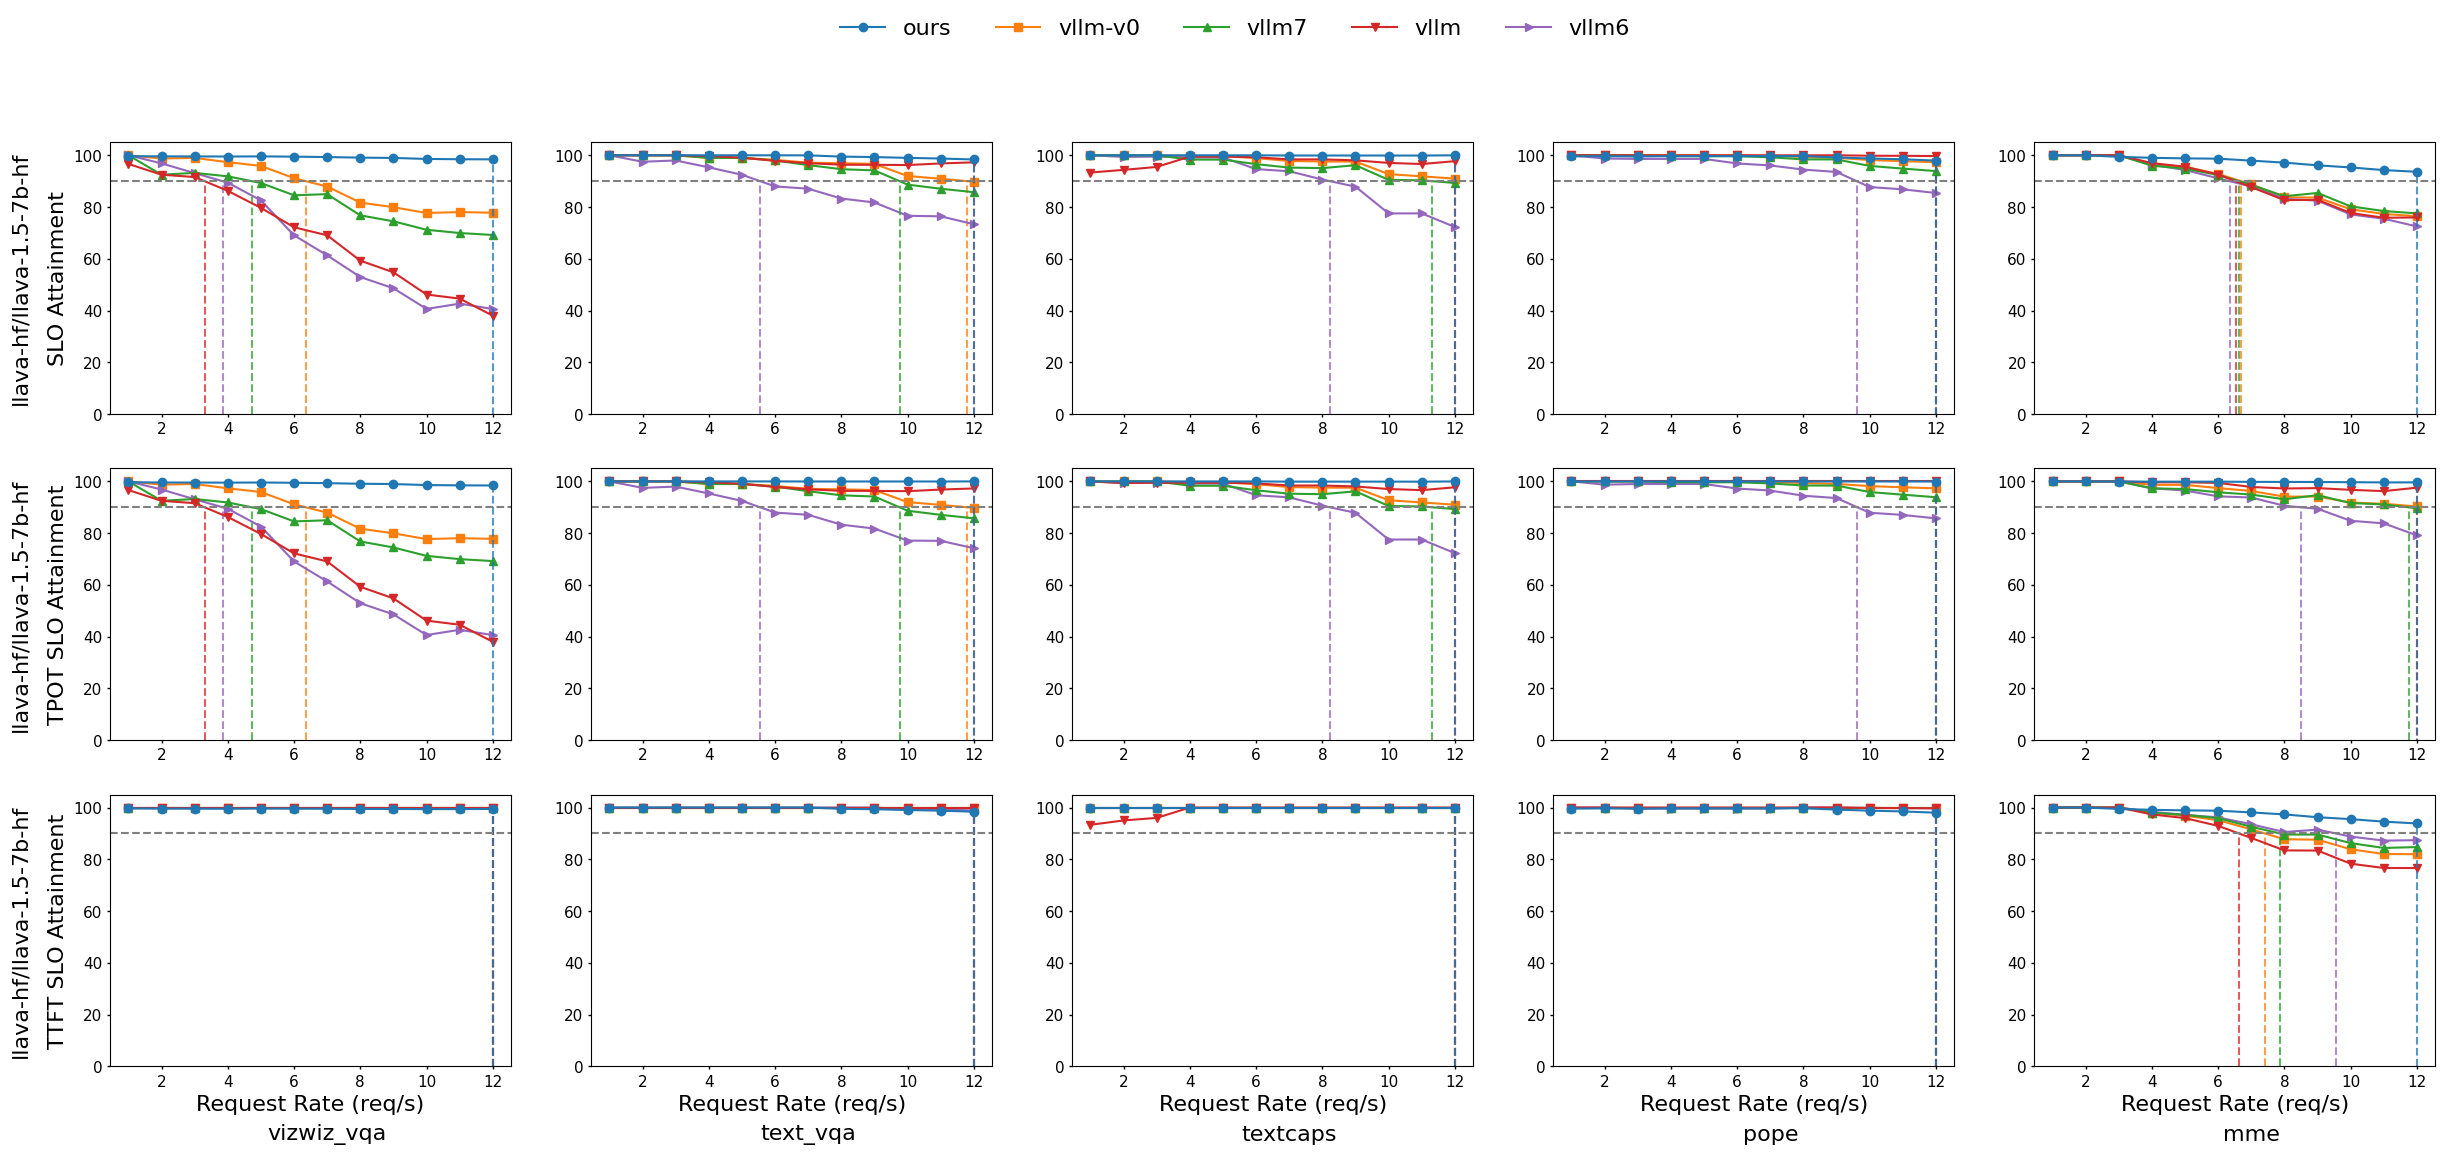

In [92]:
# visualize selected line
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

def get_intersection_points(x, y, target_y) -> list[tuple[float, float]]:
    cross_points = []

    # Check if y_i is close to target_y
    for xi, yi in zip(x, y):
        if np.isclose(yi, target_y):
            cross_points.append((xi, yi))

    # Check if each line crosses the y=target_y line
    for i in range(len(x) - 1):
        x0, x1 = x[i], x[i + 1]
        y0, y1 = y[i], y[i + 1]
        if (y0 - target_y) * (y1 - target_y) < 0:
            t = (target_y - y0) / (y1 - y0)
            x_inter = x0 + t * (x1 - x0)
            y_inter = y0 + t * (y1 - y0)
            cross_points.append((x_inter, y_inter))

    return cross_points

def draw_slo_vertical_line(x_values, y_values, slo_target, ax, **kwargs):
    cross_points = get_intersection_points(x_values, y_values, slo_target)
    if not cross_points:
        if y_values[0] < slo_target:
            ax.plot([x_values[0], x_values[0]], [-5, y_values[0]], **kwargs)
        elif y_values[-1] > slo_target:
            ax.plot([x_values[-1], x_values[-1]], [-5, y_values[-1]], **kwargs)
    for x, y in cross_points:
        ax.plot([x, x], [0, y], **kwargs)

def smooth_curve(x, y, window_size=2):
    y_smooth = []
    for i in range(len(y)):
        start = max(0, i - window_size)
        end = min(i + window_size + 1, len(y))
        window = y[start:end]
        avg = sum(window) / len(window)
        y_smooth.append(avg)
    return x, y_smooth
    
    
# parameters
figure_name = "slo_attainment"
# figure_name = "batch_policy_abligation"
# n_metrics = 3
n_metrics = 3

methods = {line_data.method for line_data in selected_line_data}
n_methods = len(methods)
n_rows = n_models * n_metrics
n_cols = n_datasets
model_id = {model: i for i, model in enumerate(models)}
id_model = {i: model for i, model in enumerate(models)}
dataset_id = {dataset: i for i, dataset in enumerate(datasets)}
id_dataset = {i: dataset for i, dataset in enumerate(datasets)}
method_id = {method: i for i, method in enumerate(methods)}
id_method = {i: method for i, method in enumerate(methods)}
marker_list = ['o', 's', '^', 'v', '>', '<', 'd', 'p', '*', 'h', 'H', 'x', '+', '.', ',', '|', '_']
color_list = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
print(f'model_id: {model_id}')
print(f'dataset_id: {dataset_id}')
print(f'method_id: {method_id}')

figsize=(6 * n_cols, 4 * n_rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = np.array(axes).reshape(n_rows, n_cols)
for line_data in selected_line_data:
    row_id = model_id[line_data.model]
    col_id = dataset_id[line_data.dataset]
    i = method_id[line_data.method]
    color = color_list[i]
    marker = marker_list[i]
    
    for k in range(n_metrics):
        ax = axes[row_id + k][col_id]
        x = line_data.request_rates
        if k == 0:
            y = line_data.slo_attainment
        elif k == 1:
            y = line_data.tpot_slo_attainment
        elif k == 2:
            y = line_data.ttft_slo_attainment
        x, y = smooth_curve(x, y)
        ax.plot(x, y, color=color, marker=marker)
        draw_slo_vertical_line(x, y, slo_target=0.9, ax=ax, color=color, linestyle='--', alpha=0.75)
    
fontsize=16
for i in range(n_models):
    for j in range(n_datasets):
        for k in range(n_metrics):
            ax = axes[i + k][j]
            ax.grid(False)
            ax.set_ylim(0, 1.05)
            
            formatter = FuncFormatter(lambda val, pos: f'{val * 100:.0f}')
            ax.yaxis.set_major_formatter(formatter)
            ax.axhline(y=0.9, color="gray", linestyle="--")
            
            if j == 0: 
                if k == 0:
                    ax.set_ylabel('SLO Attainment', fontsize=fontsize)
                elif k == 1:
                    ax.set_ylabel('TPOT SLO Attainment', fontsize=fontsize)
                elif k == 2:
                    ax.set_ylabel('TTFT SLO Attainment', fontsize=fontsize)
                    
                ax.text(-0.2, 0.5, id_model[i], transform=ax.transAxes, ha='right', va='center', rotation=90, fontsize=fontsize)
            if i == n_models - 1 and k == n_metrics - 1:
                axes[i + k][j].set_xlabel('Request Rate (req/s)', fontsize=fontsize)
                ax.text(7, -0.3, id_dataset[j], ha='center', va='bottom', fontsize=fontsize)
                
            for label in ax.get_xticklabels():
                label.set_fontsize(fontsize - 5)
            for label in ax.get_yticklabels():
                label.set_fontsize(fontsize - 5)
            ax.tick_params(axis='x', which='major', length=2, width=1, direction='out', grid_color='black', grid_alpha=1)
            ax.tick_params(axis='y', which='major', length=2, width=1, direction='out', grid_color='black', grid_alpha=1)
            ax.tick_params(which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True, direction='out')
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
            
fig.legend(
    [Line2D([0], [0], color=color_list[i], marker=marker_list[i]) for i in range(len(method_id))],
    [method for method, id in method_id.items()], 
    loc='upper center', ncol=len(method_id), fontsize=fontsize, frameon=False, bbox_to_anchor=(0.5, 1.0))

fig.savefig(os.path.join(figures_dir, f"{figure_name}.pdf"), bbox_inches="tight")

In [50]:
for line_data in selected_line_data:
    print(line_data.method, line_data.dataset, line_data.avg_tpot)

vllm-v0 vizwiz_vqa [0.010267655886078284, 0.011971199394497867, 0.014910009103586416, 0.0239735910236091, 0.022891296276676354, 0.030044744169254872, 0.03756983018023438, 0.05158010130191859, 0.05301520855627615, 0.06333236639417297, 0.06344052301187057, 0.06687480471397281]
vllm6 vizwiz_vqa [0.012128429653151243, 0.013967667498535372, 0.018802732855402574, 0.03417717677701115, 0.0326545580606486, 0.05703613382167658, 0.0744868425068527, 0.0849998142359368, 0.08846139317011345, 0.09540699435298096, 0.0968300325351773, 0.0977816397576806]
vllm7 vizwiz_vqa [0.012403371616859327, 0.014295455778860149, 0.017196947961620135, 0.024280832763859984, 0.022693115206914007, 0.03114565743611211, 0.03629347500107954, 0.05221658276606874, 0.05675079162361679, 0.06032116153122344, 0.06365610450642263, 0.0696869028013469]
vllm vizwiz_vqa [0.009316798807220129, 0.011407140681795843, 0.016500186421715562, 0.024355466462644196, 0.02228635387973128, 0.03303215755962079, 0.03430194544110372, 0.052737770712

selected_ttft 0.5
selected_tpot 0.08


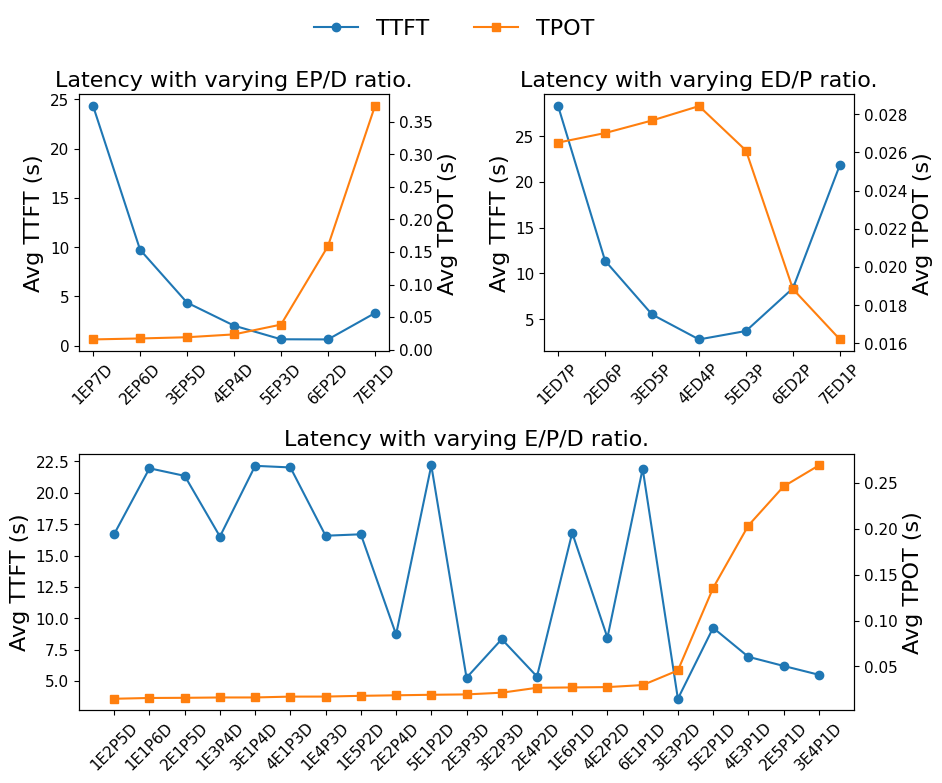

In [48]:
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

selected_ttft = TTFT_SLOs[1]
selected_tpot = TPOT_SLOs[1]
selected_dataset = "textcaps"
selected_request_rate_id = len(all_line_data[0].request_rates) // 2

print(f'selected_ttft {selected_ttft}')
print(f'selected_tpot {selected_tpot}')

n_cols = 2
n_rows = 2
figsize=(5 * n_cols, 4 * n_rows)
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.4, wspace=0.5)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
axes = [ax3, ax1, ax2]

fontsize = 16
axes[0].set_title('Latency with varying E/P/D ratio.', fontsize=fontsize)
axes[1].set_title('Latency with varying EP/D ratio.', fontsize=fontsize)
axes[2].set_title('Latency with varying ED/P ratio.', fontsize=fontsize)
patterns = [r'\d+e\d+p\d+d', r'\d+ep\d+d', r'\d+ed\d+p']
for i, pattern in enumerate(patterns):
    all_ratio_line_data = [line_data for line_data in all_line_data if line_data.dataset == selected_dataset and line_data.ttft_slo == selected_ttft and line_data.tpot_slo == selected_tpot and re.search(pattern, line_data.full_method_name)]
    if i == 0:
        all_ratio_line_data = sorted(all_ratio_line_data, key=lambda line_data: line_data.avg_tpot[selected_request_rate_id])
    
    x = [re.findall(pattern, line_data.full_method_name)[0].upper() for line_data in all_ratio_line_data]
    y1 = [line_data.avg_ttft[selected_request_rate_id] for line_data in all_ratio_line_data]
    y2 = [line_data.avg_tpot[selected_request_rate_id] for line_data in all_ratio_line_data]
    axes[i].plot(x, y1, marker=marker_list[0], color=color_list[0])
    axes[i].set_ylabel('Avg TTFT (s)', fontsize=fontsize)
    ax = axes[i].twinx()
    ax.plot(x, y2, marker=marker_list[1], color=color_list[1])
    ax.set_ylabel('Avg TPOT (s)', fontsize=fontsize)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(x, rotation=45)
    axes[i].grid(False)
    ax.grid(False)
    for label in axes[i].get_xticklabels():
        label.set_fontsize(fontsize - 5)
    for label in axes[i].get_yticklabels():
        label.set_fontsize(fontsize - 5)
    for label in ax.get_yticklabels():
        label.set_fontsize(fontsize - 5)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

fig.legend(
    [Line2D([0], [0], color=color_list[i], marker=marker_list[i]) for i in range(2)],
    ['TTFT', 'TPOT'],
    loc='upper center', ncol=len(method_id), fontsize=fontsize, frameon=False, bbox_to_anchor=(0.5, 1.0))
fig.savefig(os.path.join(figures_dir, "instance_ratio.pdf"), bbox_inches="tight")

In [49]:
import re
def criterion(line_data: LineData):
    score2 = sum(line_data.ttft_slo_attainment)
    score1 = sum(line_data.tpot_slo_attainment)
    score = score1 + score2
    return score

all_disaggregation_methods: dict[tuple[str, float, float], list[LineData]] = {}
for dataset in datasets:
    for ttft in TTFT_SLOs:
        for tpot in TPOT_SLOs:
            all_disaggregation_methods[(dataset, ttft, tpot)] = []

for line_data in all_line_data:
    if line_data.method == 'ours':
        all_disaggregation_methods[(line_data.dataset, line_data.ttft_slo, line_data.tpot_slo)].append(line_data)
        
for dataset in datasets:
    for ttft in TTFT_SLOs:
        for tpot in TPOT_SLOs:
            disaggregation_methods = all_disaggregation_methods[(dataset, ttft, tpot)]
            disaggregation_methods = sorted(disaggregation_methods, key=criterion, reverse=True)
            print(dataset, ttft, tpot, [m.full_method_name for m in disaggregation_methods[:5]])
            all_disaggregation_methods[(dataset, ttft, tpot)] = disaggregation_methods


vizwiz_vqa 0.25 0.06 ['ours-3ep5d', 'ours-2e2p4d', 'ours-2e3p3d', 'ours-6ed2p', 'ours-3e2p3d']
vizwiz_vqa 0.25 0.08 ['ours-4ep4d', 'ours-3ep5d', 'ours-2e3p3d', 'ours-2e2p4d', 'ours-5ed3p']
vizwiz_vqa 0.25 0.1 ['ours-4ep4d', 'ours-3ep5d', 'ours-2e3p3d', 'ours-2e4p2d', 'ours-6ep2d']
vizwiz_vqa 0.25 0.12 ['ours-6ep2d', 'ours-4ep4d', 'ours-5ep3d', 'ours-3e3p2d', 'ours-3ep5d']
vizwiz_vqa 0.25 0.14 ['ours-6ep2d', 'ours-4ep4d', 'ours-5ep3d', 'ours-3e3p2d', 'ours-3ep5d']
vizwiz_vqa 0.25 0.16 ['ours-6ep2d', 'ours-4ep4d', 'ours-5ep3d', 'ours-3e3p2d', 'ours-3ep5d']
vizwiz_vqa 0.5 0.06 ['ours-4ep4d', 'ours-5ed3p', 'ours-3ep5d', 'ours-6ed2p', 'ours-2e3p3d']
vizwiz_vqa 0.5 0.08 ['ours-5ep3d', 'ours-6ep2d', 'ours-4ep4d', 'ours-5ed3p', 'ours-4ed4p']
vizwiz_vqa 0.5 0.1 ['ours-6ep2d', 'ours-5ep3d', 'ours-4ep4d', 'ours-5ed3p', 'ours-3e3p2d']
vizwiz_vqa 0.5 0.12 ['ours-6ep2d', 'ours-5ep3d', 'ours-4ep4d', 'ours-5ed3p', 'ours-3e3p2d']
vizwiz_vqa 0.5 0.14 ['ours-6ep2d', 'ours-5ep3d', 'ours-4ep4d', 'ours-5ed3

C:\Users\86138\AppData\Local\Temp\ipykernel_37336\2908795531.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(methods_name))


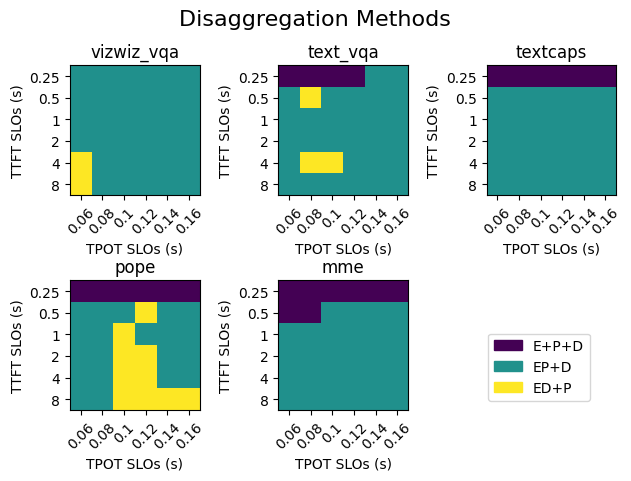

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

patterns = [r'\d+e\d+p\d+d', r'\d+ep\d+d', r'\d+ed\d+p']
def method2int(method: str):
    for i, pattern in enumerate(patterns):
        if re.fullmatch(pattern, method):
            return i
    return -1

def build_heatmap_data(selected_dataset: str):
    n_rows = len(TTFT_SLOs)
    n_cols = len(TPOT_SLOs)
    data = np.full((n_rows, n_cols), -1)

    for i in range(n_rows):
        for j in range(n_cols):
            ttft = TTFT_SLOs[i]
            tpot = TPOT_SLOs[j]
            method = all_disaggregation_methods[(selected_dataset, ttft, tpot)][0].full_method_name.split('-')[-1]
            data[i][j] = method2int(method)
    return data

n_cols = 3
n_rows = (n_datasets + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols)
axes = np.array(axes).reshape(n_rows * n_cols)

methods_name = ["E+P+D", "EP+D", "ED+P"]
figsize=(8 * n_cols, 6 * n_rows)
for dataset_id, dataset in enumerate(datasets):
    data = build_heatmap_data(dataset)
    ax = axes[dataset_id]
    heatmap = ax.imshow(data, cmap='viridis', vmin=0, vmax=len(patterns)-1)
    n_col_pixels = len(TPOT_SLOs)
    n_row_pixels = len(TTFT_SLOs)
    ax.set_xticks(np.arange(n_col_pixels))
    ax.set_yticks(np.arange(n_row_pixels))
    ax.set_xticklabels(TPOT_SLOs, rotation=45)
    ax.set_yticklabels(TTFT_SLOs)
    ax.set_xlabel('TPOT SLOs (s)')
    ax.set_ylabel('TTFT SLOs (s)')
    ax.set_title(f'{dataset}')
    # for i in range(n_col_pixels):
    #     for j in range(n_row_pixels):
    #         text = ax.text(j, i, methods_name[data[i][j]], ha='center', va='center', color='white', fontsize=8)
            
for i in range(len(datasets), axes.size):
    fig.delaxes(axes[i])

cmap = plt.cm.get_cmap('viridis', len(methods_name))
legend_elements = [
    mpatches.Patch(color=cmap(0), label='E+P+D'),
    mpatches.Patch(color=cmap(1), label='EP+D'),
    mpatches.Patch(color=cmap(2), label='ED+P')
]
last_ax = axes[-1]
# last_ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
fig.legend(handles=legend_elements, loc='lower center', ncol=1, bbox_to_anchor=(0.85, 0.15))
fig.suptitle('Disaggregation Methods', fontsize=fontsize)

plt.tight_layout()
fig.savefig(os.path.join(figures_dir, f"disaggregation_methods.pdf"), bbox_inches="tight")